### Contingency Table

1. We get the reconstruct $\hat{\mathcal{X}} \in \mathbb{R}^{K \times N \times N}$ corresponding with the true label $\mathcal{X} \in \{0,1\}^{K \times N \times N}$. 
2. We draw histogram of $\hat{\mathcal{X}}$ based on different class labels. (we get num($\hat{\mathcal{x}}|x$)), observe the shape of distribution of reconstruct tensor. 
3. Then we can use Laplace approximation to fit a gaussian distribution p($\hat{\mathcal{x}}|x$). 
4. For each $\hat{\mathcal{x}}$, calculate contingency table. 

In [1]:
import pickle
import numpy as np
import logging
from scipy.io.matlab import loadmat
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
# import model

infile = open('data/model','rb')
model = pickle.load(infile)
infile.close() 

T = model['T']        # input NATION data 
_T = model['recon_T'] # reconstruct tensor of NATION dataset

train_mask = model['train_mask']
test_mask = model['test_mask']

T_train = T[train_mask == 1]
T_test = T[test_mask == 1]
_T_train = _T[train_mask ==1]
_T_test = _T[test_mask==1]

print('T shape: ', T.shape)
print('T valid triples: ', len(np.where(T == 1)[0]))
print('T invalid triples: ', len(np.where(T == 0)[0]))
print
print('_T shape: ', _T.shape)
print
print('training size %d' % np.sum(T[train_mask==1]))
print('test size %d' % np.sum(T[test_mask==1]))

T shape:  (56, 14, 14)
T valid triples:  2024
T invalid triples:  8952
_T shape:  (56, 14, 14)
training size 621
test size 1403


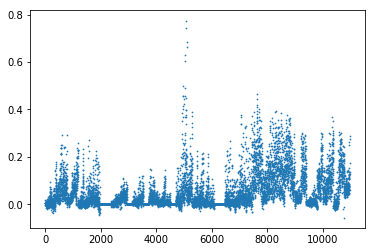

range(0, 10976)

In [8]:
plt.scatter(range(len(_T.flatten())), _T.flatten(), s = 0.5)
plt.show()
range(len(_T.flatten()))

test (1) mean 0.129635; standard deviation: 0.084599
test (0) mean 0.032655; standard deviation: 0.049056


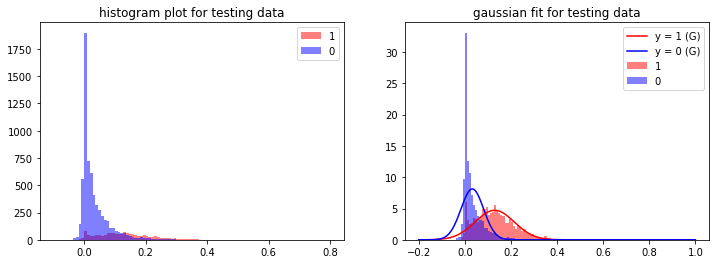

In [5]:
# histogram plot for testing data

bins = np.linspace(-0.1, 0.8, 100)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(_T_test.flatten()[T_test.flatten() == 1], bins, alpha = 0.5, color = 'red', label = '1')
plt.hist(_T_test.flatten()[T_test.flatten() == 0], bins, alpha = 0.5, color = 'blue', label = '0')
plt.legend()
plt.title('histogram plot for testing data')

#-------------------------------------------------------------------------------------------

# gaussian fit for testing data
plt.subplot(1, 2, 2)
plt.hist(_T_test.flatten()[T_test.flatten() == 1], bins, alpha = 0.5, color = 'red', label = '1', normed = True)
plt.hist(_T_test.flatten()[T_test.flatten() == 0], bins, alpha = 0.5, color = 'blue', label = '0', normed = True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(_T_test.flatten()))

# lets try the normal distribution first
# get mean and standard deviation  
m, s = stats.norm.fit(_T_test.flatten()[T_test.flatten() == 1]) 
print('test (1) mean %f; standard deviation: %f' % (m,s))
pdf_g_1 = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g_1, label="y = 1 (G)", color = 'red') # plot it

# lets try the normal distribution first
m, s = stats.norm.fit(_T_test.flatten()[T_test.flatten() == 0]) 
print('test (0) mean %f; standard deviation: %f' % (m,s))
pdf_g_0 = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g_0, label="y = 0 (G)", color = 'blue') # plot it

plt.legend()
plt.title('gaussian fit for testing data')

plt.show()

In [19]:
# laplace approximation

test_0 = _T_test.flatten()[T_test.flatten() == 0]
test_1 = _T_test.flatten()[T_test.flatten() == 1]

stats.mode(test_0)
stats.mode(test_1)

# same mode??


array([ 0.00773893,  0.00546128,  0.01600764, ...,  0.10846647,
        0.15197243,  0.11580549])

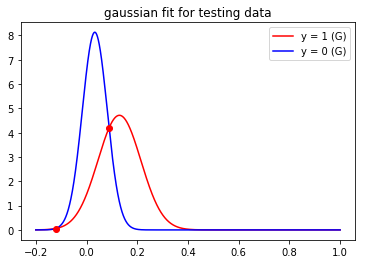

[ 0.08895801]


0.60794127460794112

In [109]:
# fit gaussian according to the mean and standard deviation of the data

import pandas as pd

plt.plot(lnspc, pdf_g_1, label="y = 1 (G)", color = 'red')
plt.plot(lnspc, pdf_g_0, label="y = 0 (G)", color = 'blue') # plot it

# find the intersections 
idx = np.argwhere(np.diff(np.sign(pdf_g_0 - pdf_g_1)))
plt.plot(lnspc[idx], pdf_g_1[idx],'ro')

plt.legend()
plt.title('gaussian fit for testing data')

plt.show()
lnspc[idx]

# print contigency table
# threshold
theta = lnspc[idx][-1]
print(theta)
predictions = np.zeros_like(T_test)
predictions[_T_test > theta] = 1

preds = pd.DataFrame(data = predictions)
trues = pd.DataFrame(data = T_test)

table = pd.crosstab(predictions, T_test, rownames=['pred'], colnames=['true'], margins = True)/len(trues)
table

f1_score(T_test, predictions)

In [54]:
# key: prediction; value: label
test_dict = {}

for i in range(len(T_test)):
    test_dict[_T_test[i]] = T_test[i]

6755

In [83]:
# calculate contigency table for each possible x, 
# show the result in line plot
trues = pd.DataFrame(data = T_test)
TP = []
FP = []
FN = []
TN = []
precision = []
recall = []
fmeasure = []

for theta in _T_test:
    predictions = np.zeros_like(T_test)
    predictions[_T_test > theta] = 1
    preds = pd.DataFrame(data = predictions)
    table = pd.crosstab(predictions, T_test, rownames=['pred'], colnames=['true'], margins = True)/len(trues)
    TP.append(table[1][1])
    FP.append(table[1][0])
    FN.append(table[0][1])
    TN.append(table[0][0])
    precision.append(TP[-1]/(TP[-1] + FP[-1]))
    recall.append(TP[-1]/(TP[-1] + FN[-1]))
    fmeasure.append(2 * precision[-1]* recall[-1]/(precision[-1] + recall[-1])) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


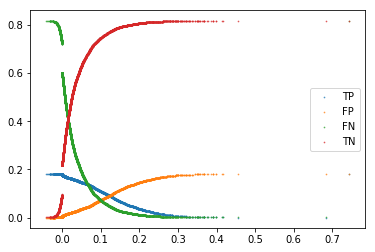

In [84]:
plt.clf()
alpha = 0.7
s = 0.5
plt.scatter(_T_test, TP, alpha=alpha, s=s, label='TP')
plt.scatter(_T_test, FP, alpha=alpha, s=s, label='FP')
plt.scatter(_T_test, FN, alpha=alpha, s=s, label='FN')
plt.scatter(_T_test, TN, alpha=alpha, s=s, label='TN')
plt.legend()
plt.show()

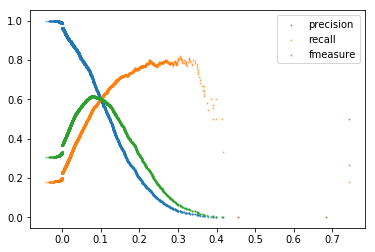

In [103]:
plt.clf()
alpha = 0.5
s = 1
plt.scatter(_T_test, precision, alpha=alpha, s=s, label='precision')
plt.scatter(_T_test, recall, alpha=alpha, s=s, label='recall')
plt.scatter(_T_test, fmeasure, alpha=alpha, s=s, label='fmeasure')
plt.legend()
plt.show()

In [104]:
# find the threshold which gives the biggest fmeasure

for i, fm in enumerate(fmeasure):
    if fm == max(fmeasure):
        print(_T_test[i])

0.0780194012092


### Fit the predictions into classifiers 

#### Fit Logistic Regression 

In [108]:
# fit reconstructed x into classifiers

# logistic regression

from sklearn.linear_model import LogisticRegression

# features
_T_tr = _T[train_mask == 1].flatten()
_T_tr = _T_tr.reshape(_T_tr.shape[0],1)
_T_te = _T[test_mask == 1].flatten()
_T_te = _T_te.reshape(_T_te.shape[0],1)

# labels
T_tr = T[train_mask == 1].flatten()
#T_tr = T_tr.reshape(T_tr.shape[0],1)
T_te = T[test_mask == 1].flatten()
#T_te = T_te.reshape(T_te.shape[0],1)

clf = LogisticRegression().fit(_T_tr, T_tr)
predictions = clf.predict(_T_te)
roc_auc_score(T_te, predictions)
f1_score(T_te, predictions)

0.3888888888888889

#### Fit SVM

In [112]:
from sklearn import svm 

clf = svm.SVC(kernel='linear', class_weight='balanced')
clf.fit(_T_tr, T_tr)
predictions_svm = list(clf.predict(_T_te))

f1_score(T_te, predictions_svm)

0.60978835978835977